# 准备

In [1]:
import sys
import os
sys.path.append("/Users/jkguo/workspace/fit-ops-check/detect_experiment_tools")
import torch    
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
from layers.Embed import DataEmbedding
from layers.Conv_Blocks import Inception_Block_V1   #convolution block used for convoluting the 2D time data, changeable

from experiments.utils.sample_library import SampleDoc, SampleLibrary
from experiments.utils.metric_detect_request import DetectRequest
from experiments.normalizer.max_percent_normalizer import MaxPercentNormalizer
from experiments.utils.tag_util import SmoothFlag

import model_util

device = (
    "cuda" if torch.cuda.is_available() 
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

# 数据加载

In [2]:
data_root_path = "/Users/jkguo/workspace/fit-ops-check/ops_metric_training_data"
normal_db_path = os.path.join(data_root_path, "db/ops_check_sample/ops-check-normal-sample-20240525.db")


class SampleDataSet(torch.utils.data.Dataset):

    def __init__(self, db_path: str):
        self.smooth_dct = model_util.build_smooth_dct()
        self.data, self.docs = self.__load(db_path)
    def __is_match_smooth(self, doc: SampleDoc):
        s = doc.metric.metric_data.metric[0].values[:180]
        x = np.array(
            [
                self.smooth_dct.convert_format(np.array(s))
            ]
        )
        y = self.smooth_dct.tree.predict(x)
        return int(y[0])in [SmoothFlag.SMOOTH]
    def __load(self, db_path):
        data = []
        docs = []
        db = SampleLibrary(db_path)
        for idx, row in db.df.iterrows():
            doc = SampleDoc()
            doc.load_from_str(row["doc"])
            if doc.metric_unit() < 60:
                continue
            if not self.__is_match_smooth(doc):
                continue
            doc.padding_pre_das_for_second_metrics_by_randon_avg()
            if len(doc.metric.metric_data.metric) != 8:
                continue
            x = []
            y = []
            days = len(doc.metric.metric_data.metric)
            for i in range(days - 1, -1, -1):
                v = doc.metric.metric_data.metric[i].values
                if i == 0:
                    x.extend(v[:91])
                    y.extend(v[91:181])
                else:
                    x.extend(v[:181])
            x = np.squeeze(np.array(x, dtype=np.float32))
            y = np.squeeze(np.array(y, dtype=np.float32))
            data.append((x, y))
            docs.append(doc)
            if len(data) == 20000:
                break
        print(f"loaded {len(data)} cases")
        return data, docs
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]


train_dataset = SampleDataSet(normal_db_path)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

/Users/jkguo/miniforge3/envs/torch_env/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


load 63298 docs from /Users/jkguo/workspace/fit-ops-check/ops_metric_training_data/db/ops_check_sample/ops-check-normal-sample-20240525.db
loaded 4015 cases


(1358,) (90,)


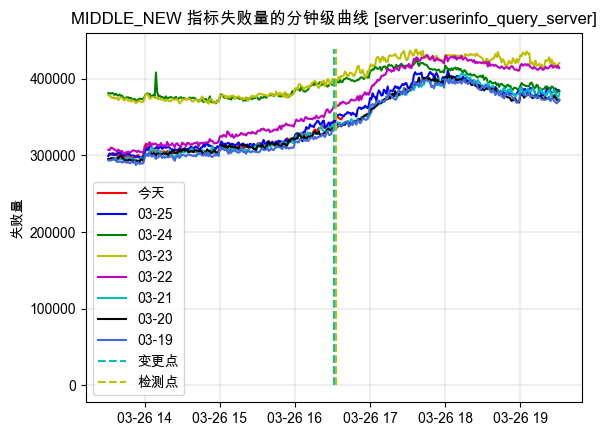

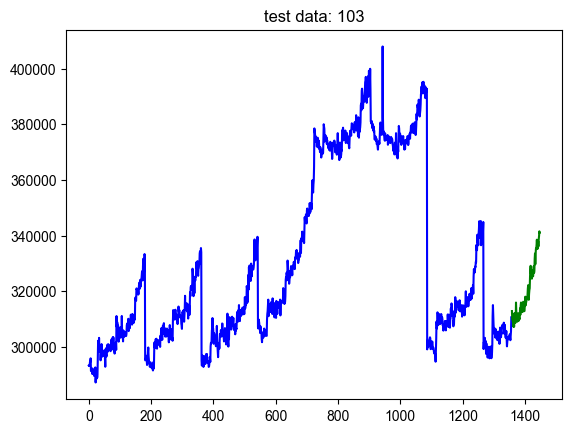

In [3]:
import matplotlib.pyplot as plt

idx = 103
x, y = train_dataset[idx]
print(x.shape, y.shape)
train_dataset.docs[idx].draw(days=range(8))
s_x = x[:]
plt.title(f"test data: {idx}")

def plot_line(x, y):
    plt.plot(range(len(x)), x, color="blue", label="x")
    plt.plot(range(len(x), len(x) + len(y)), y, color="green", label="y")
    plt.show()

plot_line(s_x, y)

In [4]:
# 序列周期fft
from layers.TimesNet import FFT_for_Period

t_x = torch.Tensor(x).unsqueeze(0).unsqueeze(2)
print(t_x.shape)
FFT_for_Period(t_x, k=3)

torch.Size([1, 1358, 1])


(array([1358,  679,  226]),
 tensor([[24520978.0000, 12208448.0000,  4978201.5000]]))

# 模型构建

In [5]:
from layers.TimesNet import Model


class Configs(object):

    def __init__(self):
        # task name, options:[long_term_forecast, short_term_forecast, imputation, classification, anomaly_detection]
        self.task_name = "long_term_forecast"
        self.seq_len = 1358
        self.pred_len = 90
        self.top_k = 2
        # dimension of model
        self.d_model = 32
        # dimension of fcn
        self.d_ff = 128
        # kernels for Inception
        self.num_kernels = 6
        # num of encoder layers
        self.e_layers = 2
        # num of decoder layers
        self.d_layers = 1
        # encoder input size
        self.enc_in = 1
        # decoder input size
        self.dec_in = 1
        # output size
        self.c_out = 1
        # "time features encoding, options:[timeF, fixed, learned]"
        self.embed = "timeF"
        # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
        self.freq = "t"
        # dropout
        self.dropout = 0.1
        # start token length
        self.label_len = 1358 - 20


net = Model(Configs())
p_count = 0
for name, p in net.named_parameters():
    # print(f"{name}: {np.prod(p.shape)}")
    p_count += np.prod(p.shape)
print(net)
print(f"all parameters count : {p_count}")

Model(
  (model): ModuleList(
    (0-1): 2 x TimesBlock(
      (conv): Sequential(
        (0): Inception_Block_V1(
          (kernels): ModuleList(
            (0): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
            (1): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (3): Conv2d(32, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
            (4): Conv2d(32, 128, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
            (5): Conv2d(32, 128, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
          )
        )
        (1): GELU(approximate='none')
        (2): Inception_Block_V1(
          (kernels): ModuleList(
            (0): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): Conv2d(128, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

# 训练

In [6]:
import time

net.to(device)
model_optim = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.MSELoss()
pred_len = 90
label_len = 1358 - 90
train_loss = []
time_now = time.time()
iter_count = 0
net.train()
for epoch in range(10):
    for i, (batch_x, batch_y) in enumerate(train_data_loader):
        iter_count += 1
        batch_x = batch_x.unsqueeze(2).float().to(device)
        batch_y = batch_y.unsqueeze(2).float().to(device)
        model_optim.zero_grad()
        # decoder input(didn't use in TimesNet case)
        dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)
        # encoder - decoder
        outputs = net(batch_x, None, dec_inp, None)
        # [M，S，MS]；M：多元变量预测多元变量，S：单变量预测单变量，MS：多元变量预测单变量
        f_dim = 0 # -1 if self.args.features == 'MS' else 0 
        outputs = outputs[:, -pred_len:, f_dim:]
        batch_y = batch_y[:, -pred_len:, f_dim:].to(device)
        loss = criterion(outputs, batch_y)
        train_loss.append(loss.item())
        # When train rounds attain some 100-multiple, print speed, left time, loss. etc feedback
        if (i + 1) % 10 == 0:
            print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
            speed = (time.time() - time_now) / iter_count
            print('\tspeed: {:.4f}s/iter;'.format(speed))
            iter_count = 0
            time_now = time.time()
        # 优化
        loss.backward()
        model_optim.step()

	iters: 10, epoch: 1 | loss: 4551165870080.0000000
	speed: 14.1355s/iter;
	iters: 10, epoch: 2 | loss: 4742069092352.0000000
	speed: 15.0304s/iter;
	iters: 10, epoch: 3 | loss: 1642131619840.0000000
	speed: 15.4468s/iter;
	iters: 10, epoch: 4 | loss: 754611847168.0000000
	speed: 15.3246s/iter;
	iters: 10, epoch: 5 | loss: 274905432064.0000000
	speed: 15.3169s/iter;
	iters: 10, epoch: 6 | loss: 2007633362944.0000000
	speed: 15.3326s/iter;
	iters: 10, epoch: 7 | loss: 2242950201344.0000000
	speed: 15.3395s/iter;
	iters: 10, epoch: 8 | loss: 177732567040.0000000
	speed: 15.3439s/iter;
	iters: 10, epoch: 9 | loss: 41066504192.0000000
	speed: 15.4254s/iter;
	iters: 10, epoch: 10 | loss: 383065784320.0000000
	speed: 15.4674s/iter;


# 预测

torch.Size([256, 1358, 1]) torch.Size([256, 90, 1])


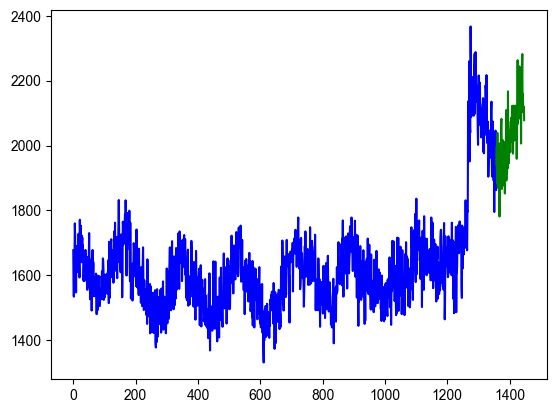

pred_y:  (1448,)


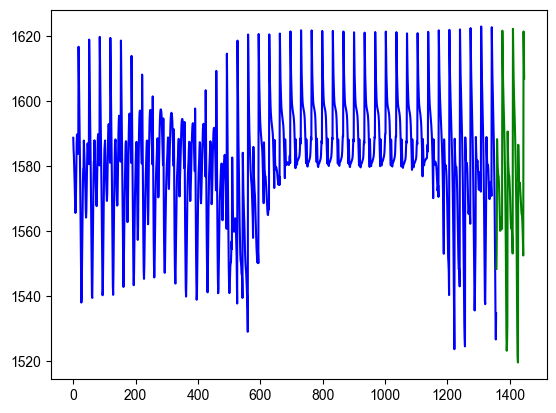

In [10]:
x, y = next(iter(train_data_loader))
org_x, org_y = x, y
x = x.unsqueeze(2).float().to(device)
y = y.unsqueeze(2).float().to(device)
print(x.shape, y.shape)

net.eval()
with torch.no_grad():
    dec_out = net.forecast(x, None, y, None)
    dec_out.shape

idx = 4
plot_line(org_x[idx], org_y[idx])
pred_y = dec_out[idx].squeeze(0).squeeze(1).detach().cpu().numpy()
print("pred_y: ", pred_y.shape)
plot_line(pred_y[: 1358], pred_y[-90:])